In [1]:
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO
import itertools as it

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import pairwise_distances

from scipy.optimize import minimize

In [2]:
def get_p_test(Q):
    p_test = {}
    for ix, fname in enumerate(files):
        p_test[fname] = list(zip(classes, Q[ix, :]))
    return p_test

def get_res(p_test):
    manip = [(f, c) for (f, c) in p_test.items() if '_manip' in f]
    #print(len(p_test), len(manip))

    unalt = [(f, c) for (f, c) in p_test.items() if '_unalt' in f]
    #print(len(p_test), len(unalt))

    unalt_tmp = unalt.copy()
    manip_tmp = manip.copy()
    #print(len(unalt_tmp), len(manip_tmp))

    t = int(0.1*1320)
    #print(t)

    res = []

    c_counts = defaultdict(int)
    for _ in range(1320):
        skip_f = set([k for (k, _) in res])
        unalt_tmp = [(f, sorted(p, key=lambda t: t[-1], reverse=True)) for (f, p) in unalt_tmp if f not in skip_f]
        unalt_tmp = sorted(unalt_tmp, key=lambda t: t[-1][0], reverse=True)
        f, p = unalt_tmp[0]
        c, _ = p[0]
        res.append((f, c))
        c_counts[c] += 1

        if c_counts[c] == t:
            unalt_tmp = [(f, [(k, v) for (k, v) in p if k != c]) for (f, p) in unalt_tmp]

    c_counts = defaultdict(int)
    for _ in range(1320):
        skip_f = set([k for (k, _) in res])
        manip_tmp = [(f, sorted(p, key=lambda t: t[-1], reverse=True)) for (f, p) in manip_tmp if f not in skip_f]
        manip_tmp = sorted(manip_tmp, key=lambda t: t[-1][0], reverse=True)
        f, p = manip_tmp[0]
        c, _ = p[0]
        res.append((f, c))
        c_counts[c] += 1

        if c_counts[c] == t:
            manip_tmp = [(f, [(k, v) for (k, v) in p if k != c]) for (f, p) in manip_tmp]

    #print(len(res))
    
    return res

In [3]:
with open('/home/mephistopheies/storage2/data/camera-model-id/tmp/p_test_985_m1_u0.pkl', 'rb') as f:
    p_test = pickle.load(f)
    
classes = sorted([k for (k, _) in list(p_test.values())[0]])

Q = np.zeros((len(p_test), len(classes)))

files = []
for fname, d in p_test.items():    
    d = dict(d)
    for ix, c in enumerate(classes):
        Q[len(files), ix] = d[c]
    files.append(fname)

In [4]:
Q_all = Q.copy()
ix_manip = [i for (i, fname) in enumerate(files) if '_manip' in fname]
Q_manip = Q_all[ix_manip, :]
ix_unalt = [i for (i, fname) in enumerate(files) if '_unalt' in fname]
Q_unalt = Q_all[ix_unalt, :]

In [6]:
def get_P(betas):
    P = Q*betas
    P = P/P.sum(axis=1)[:, np.newaxis]
    return P

def loss(betas):
    P = get_P(betas)
    mP = P.sum(axis=0)/P.shape[0]
    l = (mP*np.log(mP)).sum()
    return l

def d_loss(betas):
    P = get_P(betas)
    mP = P.sum(axis=0)/P.shape[0]
    dl = np.zeros(P.shape[1])

    z = 1 - np.log(mP)

    for c in range(P.shape[1]):
        dl[c] = -z[c]*P[:, c].sum()/(P.shape[0]*betas[c])

        a = 0    
        for i in range(P.shape[1]):
            b = 0
            for j in range(P.shape[0]):
                if Q[j, i] > 0:
                    b += Q[j, c]*P[j, i]*P[j, i]/Q[j, i]

            a += z[i]*b/(P.shape[0]*betas[i])

        dl[c] += a
        
    return -dl

In [7]:
Q = Q_manip.copy()

In [8]:
max_iter = 1500
lr = 10
b = np.ones(Q.shape[1])
log = []

l = loss(b)
log.append((l, b))
for ix in tqdm_notebook(range(max_iter)):
    b += lr*d_loss(b)
    l = loss(b)
    log.append((l, b))
    
    if len(log) > 1 and log[-1][0] > log[-2][0]:
        print('x')
        lr /= 0.1
        b = log[-2][1]
        log = log[:-1]

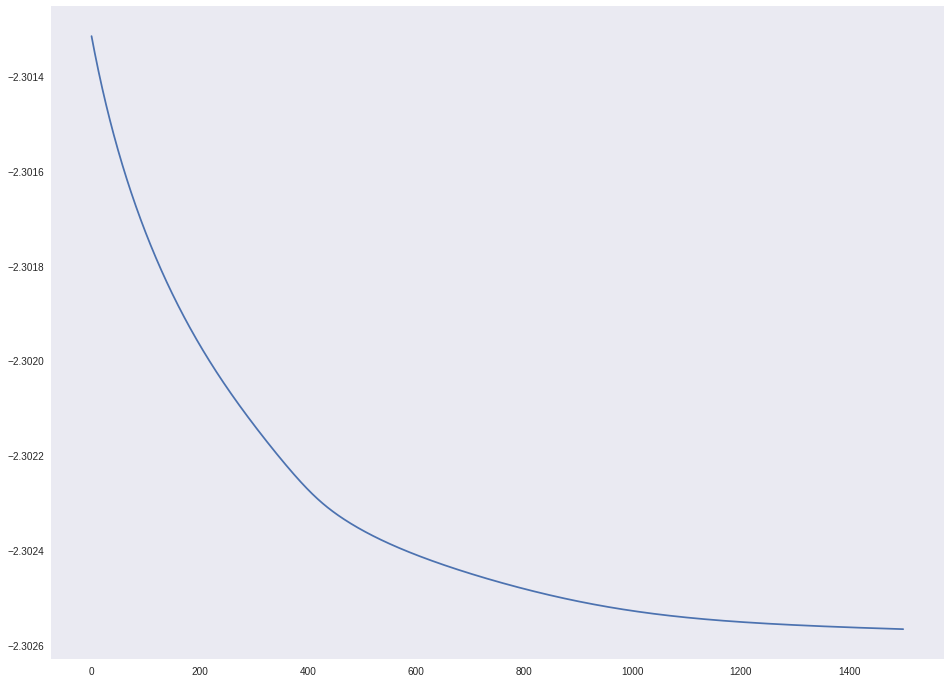

In [10]:
plt.plot([k for (k, _) in log])

In [11]:
b_manip = sorted(log, key=lambda t: t[0])[0][1]
b_manip

array([ 0.11110965,  0.51430941,  0.56305932,  2.50538912,  1.7351372 ,
        0.13205447,  0.27820976,  0.16294118,  0.08028309,  0.05591064])

In [13]:
Q = Q_unalt.copy()

In [14]:
max_iter = 1500
lr = 10
b = np.ones(Q.shape[1])
log = []

l = loss(b)
log.append((l, b))
for ix in tqdm_notebook(range(max_iter)):
    b += lr*d_loss(b)
    l = loss(b)
    log.append((l, b))
    
    if len(log) > 1 and log[-1][0] > log[-2][0]:
        print('x')
        lr /= 0.1
        b = log[-2][1]
        log = log[:-1]

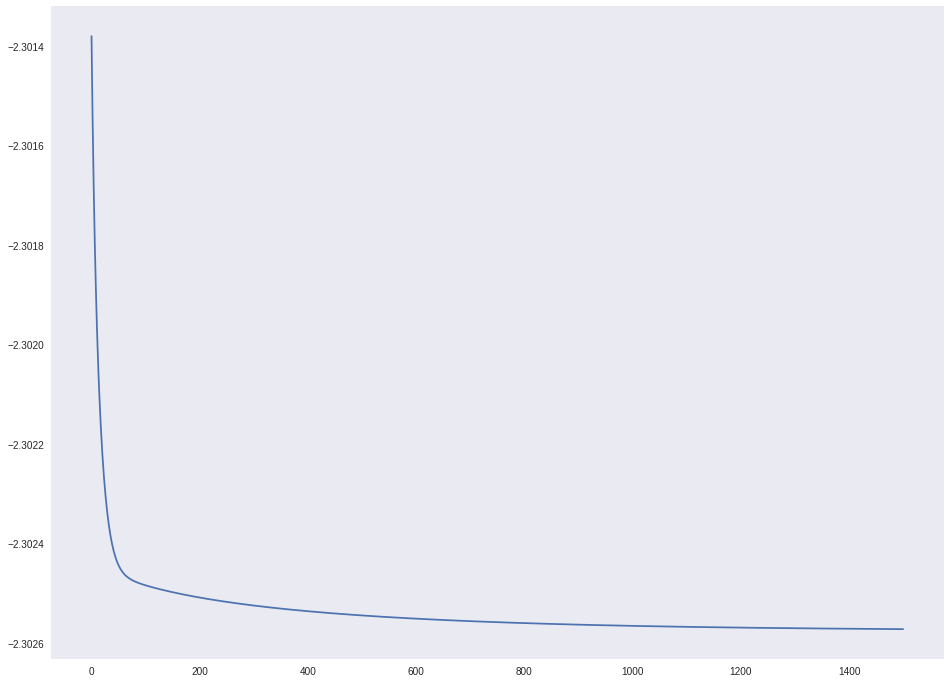

In [15]:
plt.plot([k for (k, _) in log])

In [16]:
b_unalt = sorted(log, key=lambda t: t[0])[0][1]
b_unalt

array([ 0.78175116,  0.40787891,  1.11580678,  1.50278838,  0.97310999,
        0.62910968,  1.02945156,  1.67159366,  0.6980976 ,  0.21725313])

In [21]:
P = Q_all.copy()
P[ix_manip, :] = P[ix_manip, :]*b_manip
P[ix_unalt, :] = P[ix_unalt, :]*b_unalt

P = P/P.sum(axis=1)[:, np.newaxis]

In [37]:
classes

['HTC-1-M7',
 'LG-Nexus-5x',
 'Motorola-Droid-Maxx',
 'Motorola-Nexus-6',
 'Motorola-X',
 'Samsung-Galaxy-Note3',
 'Samsung-Galaxy-S4',
 'Sony-NEX-7',
 'iPhone-4s',
 'iPhone-6']

In [12]:
# b = sorted(log, key=lambda t: t[0])[0][1]
# b

In [8]:
# P = Q*b
# P = P/P.sum(axis=1)[:, np.newaxis]

In [28]:
Q_all.sum(axis=0)

array([ 268.96454604,  274.19298575,  257.9740937 ,  238.98548065,
        254.75811932,  272.26134345,  264.80314739,  262.33274829,
        271.37597727,  274.35155815])

In [25]:
P.sum(axis=0)

array([ 264.37603066,  264.05995935,  263.73939393,  261.98259615,
        266.10835959,  264.43006598,  263.48521577,  262.72581338,
        265.306905  ,  263.7856602 ])

In [27]:
betas = b
res_sgd = get_res(get_p_test(P))

res = get_res(get_p_test(Q_all))

In [29]:
d = {}
res = dict(res)
res_sgd = dict(res_sgd)
for fname in res.keys():
    c = res[fname]
    c_sgd = res_sgd[fname]
    
    if c != c_sgd:
        d[fname] = (c, c_sgd)

In [30]:
len(d)

32

In [21]:
# res_dbg = []
# for i, fname in enumerate(files):
#     res_dbg.append((fname, classes[np.argmax(P[i, :])]))

In [22]:
# pd.Series([c for (_, c) in res_dbg]).value_counts()

In [23]:
# d = {}
# res = dict(res)
# res_dbg = dict(res_dbg)
# for fname in res.keys():
#     c = res[fname]
#     c_dbg = res_dbg[fname]
    
#     if c != c_dbg:
#         d[fname] = (c, c_dbg)

In [36]:
res = res_sgd.items()

out_dir = '/home/mephistopheies/storage2/data/camera-model-id/submit/'

# with open(os.path.join(out_dir, 'submit__unalt.csv'.lower()), 'w') as f:
#     f.write('fname,camera\n')
#     for fname, c in res:
#         if '_unalt' in fname:
#             f.write('%s,%s\n' % (fname, c))
#         else:
#             f.write('%s,%s\n' % (fname, 'no_class'))
            
            
# with open(os.path.join(out_dir, 'submit__manip.csv'.lower()), 'w') as f:
#     f.write('fname,camera\n')
#     for fname, c in res:
#         if '_manip' in fname:
#             f.write('%s,%s\n' % (fname, c))
#         else:
#             f.write('%s,%s\n' % (fname, 'no_class'))
            
            
with open(os.path.join(out_dir, 'submit.csv'.lower()), 'w') as f:
    f.write('fname,camera\n')
    for fname, c in res:
        f.write('%s,%s\n' % (fname, c))